# Functional alignment
**V.0.1 - Alpha testing, [contributions](#contributions)**

Comparing between or aggregating across individuals is foundational to many experiments in Psychology. However, individual variability that is irrelevant to the question of interest contributes measurement noise. For instance, if measuring response time, then fatigue may differ between individuals and could dilute the task-related effect of interest. 

In the case of fMRI, differences in anatomy are a big source of variability. Several useful methods have been created to stretch, squish, and twist an individual's brain into a standard anatomical space that can be used to compare data across participants. However, even the best of these procedures is unable to perfectly match the anatomy between participants. Even if perfected, distorting the anatomy may be not be enough. We care primarily about brain function, which does not map consistently to detailed anatomy. Hence an alternative approach is to **align brains based on shared functional activity rather than shared anatomical landmarks.**

Below we will consider methods for combining data across participants. We will begin with methods that employ this approach to eliminate idiosyncratic activity and noise when calculating fMRI reliability (intersubject correlation, ISC, [Hasson et al., 2004](https://doi.org/10.1126/science.1089506)) and connectivity (intersubject functional correlation, ISFC, [Simony et al., 2016](https://doi.org/10.1038/ncomms12141)). Building on this, we will then examine ways of using across-participant connectivity to functionally align brains from different individuals into a common feature space (shared response modeling, SRM).

ISC and ISFC are really useful for understanding the coupling in brain activity between individuals but doesn't provide us a way to align participants. To align participants functionally we are going to perform Shared Response Modeling (SRM) which creates a mapping between an individual's brain data and a representation that is shared across participants. An individual's brain data can then be analyzed in this low dimensional shared space for decreased noise.

## Goal of this script
    1. To run intersubject correlation (ISC)
    2. To run intersubject functional correlation (ISFC)
    3. To run shared response modeling (SRM)


## Table of Contents
[1. The ISC-ISFC_Workflow](#ISC_wf)  
>[1.1 Data File Preparation](#data_prep_isc)  
>[1.2 Compute ISC](#isc_compute)  
>[1.3 Create mask from ISC results](#mask_isc)  
>[1.4 Compute ISFC](#isfc_compute)  
>[1.5 Cluster ISFC](#clust_isfc)  
>[1.6 Permute ISFC](#perm)  

[2. The SRM_Workflow](#srm_wf)  
>[2.1 Data File Preparation](#data_prep_srm)  
>[2.2 SRM: Training data](#srm_training)  
>[2.3 SRM: Testing data](#srm_testing)  
>[2.4 Time segment matching](#time_seg)

### Exercises
>[Exercise 1](#ex1)  
>[Exercise 2](#ex2)  
>[Exercise 3](#ex3)  
>[Exercise 4](#ex4)  
>[Exercise 5](#ex5)  
>[Exercise 6](#ex6)  
>[Exercise 7](#ex7)  
>[Exercise 8](#ex8)  
>[Exercise 9](#ex9)   
>[Novel contribution](#novel)  

## 1. The ISC-ISFC Workflow <a id="ISC_wf"></a>

The functional connectivity methods that we used in past weeks compared time series of BOLD activity to infer how different regions of the brain were interacting. However, BOLD activity contains multiple components ([Figure a](#fig1)):
1. Task-based/stimulus-evoked signal
2. Intrinsic, spontaneous fluctations in neural activity that are participant specific
3. Scanner or physiological noise

ISC and ISFC are methods that extend functional connectivity measures across subjects. These procedures help to isolate the signal evoked by the task or stimulus since the only activity coupling that ought to exist between subjects is likely a result of task driven activity.

[Figure b,c](#fig1) shows how ISC differs from functional connectivity: rather than correlating brain regions, which preserve participant-specific noise, ISC correlates between the brains of participants in order to capture only the patterns of brain activity that are shared, rather than what is participant specific. In ISC this correlation is done for every voxel in the brain in order to get a full brain map. [Figure e](#fig1) represents this as the diagnonal in which each voxel in subject X is correlated with the 'matched' voxel in subject Y.

Note, if you were to perform ISC between all N participants you would need to perform ISC (N^2 - N)/2 times. With 30 participants and an average brain size this could mean you have to perform tens of billions of correlations. This isn't prohibitive but it also makes it harder to interpret since it is unclear which ISC maps to use for each participant. To simplify the computational requirements and the interpretation it is typical for ISC to only compare each individual participant with the average of all other participants.

[Figure d](#fig1) shows ISFC: the correlation of every voxel in a participant with every other voxel in another participant. This is like FCMA except it is between participants rather than within participants. In fact, these analyses use the same computational tricks. ISFC is valuable because it allows us to identify activity coupling in voxels that are not aligned across participants: the off diagonal in [Figure e](#fig1) represents correlations for voxels in different parts of the brain. The computational requirements of this are even higher since we have to do this for every pair of voxels so here it is even more necessary to use the average across participants.

<a id="fig1"></a>![alt text](https://media.springernature.com/m685/nature-assets/ncomms/2016/160718/ncomms12141/images/ncomms12141-f1.jpg)

The following sequence of steps are necessary for successfully running ISC and ISFC using [BrainIAK](http://brainiak.org/). 

1. [**Data Preparation:**](#data_prep_isc) Organize a data directory with fMRI subject data that you want to process. All subjects must be in the same anatomical space for analysis. Also you need to create a whole brain mask.  
        
2. [**Compute ISC:**](#isc_compute)  The ISC function computes a correlations across subjects for corresponding voxels in the mask. It uses the `compute_correlation` function in BrainIAK, which is optimized for fast execution (and was used for FCMA in the previous week).

3. [**Create mask from ISC results:**](#mask_isc) Threshold the correlations computed in ISC and create a mask for ISFC analysis. 

4. [**Compute ISFC:**](#isfc_compute) The ISFC function computes correlations for every voxel in one subject with the every other voxel averaged across subjects.

5. [**Cluster the ISFC results:**](#clust_isfc) Create clusters based on the correlation values. 

6. [**Perform ISFC permutation:**](#perm) Perform permutation tests to determine the significance of the results.

In [1]:
import brainiak.isfc
from brainiak import image, io
from brainiak.fcma.util import compute_correlation
import nibabel as nib
import numpy as np
from scipy import stats
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
import sys
import os
from nilearn import plotting
import scipy.spatial.distance as sp_distance
from sklearn.manifold import TSNE
from scipy import stats
import brainiak.funcalign.srm

import matplotlib.pyplot as plt
%matplotlib inline

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1.1 Data File Preparation <a id="data_prep_isc"></a>

**The dataset**

For this script we will use the "Pieman" dataset from [Simony et al., 2016](https://doi.org/10.1038/ncomms12141), which has been verified to be free of any subject-identifiable information. A description of the dataset is as follows:

18 native English speakers were scanned (15 females, ages: 18–31), corresponding to the replication dataset from the Pieman study.

Subjects were scanned in a 3T full-body MRI scanner (Skyra; Siemens) with a sixteen-channel head coil. For functional scans, images were acquired using a T2* weighted echo planer imaging (EPI) pulse sequence [repetition time (TR), 1500 ms; echo time (TE), 28 ms; flip angle, 64°], each volume comprising 27 slices of 4 mm thickness with 0 mm gap; slice acquisition order was interleaved. In-plane resolution was 3×3 mm [field of view (FOV), 192×192 mm]. Anatomical images were acquired using a T1-weighted magnetization-prepared rapid-acquisition gradient echo (MPRAGE) pulse sequence (TR, 2300 ms; TE, 3.08 ms; flip angle 9°; 0.89 mm3 resolution; FOV, 256 mm2). To minimize head movement, subjects’ heads were stabilized with foam padding.

Stimuli were presented using the [Psychophysics toolbox](http://psychtoolbox.org/) ([Brainard, 1997](https://www.ncbi.nlm.nih.gov/pubmed/9176952); [Pelli, 1997](https://www.ncbi.nlm.nih.gov/pubmed/9176953)). Subjects were provided with an MRI compatible in-ear mono earbuds (Sensimetrics Model S14), which provided the same audio input to each ear. Additionally, MRI-safe passive noise-canceling headphones were provided. Stimuli for the experiment were generated from a 7 min real life story (["Pie Man", Jim O'Grady](https://www.youtube.com/watch?v=3nZzSUDECLo)) recorded at a live storytelling performance (["The Moth" storytelling event](https://themoth.org/), New York City). Subjects listened to the story from beginning to end (intact condition).

Functional data were preprocessed and analyzed using [FSL](www.fmrib.ox.ac.uk/fsl), including correction for head motion and slice-acquisition time, spatial smoothing (6 mm FWHM Gaussian kernel), and high-pass temporal filtering (140 s period). Preprocessed functional data were aligned to coplanar and high-resolution anatomicals and the standard MNI152 brain.

**Loading and preparing the data:**

BrainIAK has methods to efficiently load data.

> *load_images:* reads data from all subjects in a list that you provide. This is like the function load_images_from_dir but here we specify the names manually. 

> *load_boolean_mask:* Create a binary mask from a brain volume

> *mask_images:* Loads the brain images and masks them with the mask provided

> *image.MaskedMultiSubjectData.from_masked_images:* Creates a list of arrays, with each item in the list corresponding to one subject's data. This data format is accepted by the BrainIAK ISC and ISFC function.

In [2]:
# Set up directories
dir = '/opt/public_FMRI/Pieman2/'
dir_mask = dir + 'masks/'

mask_name = dir_mask + 'avg152T1_gray_3mm.nii.gz'

fnames = []
for subj in range(1, 5):
    fnames += [dir + 'sub-0' + format(subj, '02') + '/func/sub-0' + format(subj, '02') + '-task-intact1.nii']

# Where do you want to store the data
dir_out ='/home/brainiak/analysis/'

print('Loading data from', len(fnames), 'subjects')

Loading data from 4 subjects


In [3]:
# Create images of the data
images = io.load_images(fnames)  # Load the brain images from the specified paths

**Exercise 1**<a id="ex1"></a> Create a brain mask from the file in *mask_name*. Use [io.load_boolean_mask](http://brainiak.org/docs/brainiak.html?highlight=load%20boolean%20mask#brainiak.io.load_boolean_mask) and a predicate function to mask the ventricles and voxels outside of the brain. Visualize the output of the mask by plotting the 30th Z slice.

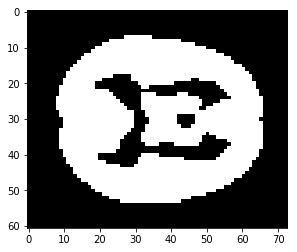

In [4]:
# Insert code below

# Specify the threshold for masking voxels
mask_func = lambda x: x > 50

# Create a boolean mask of participant data
brain_mask = io.load_boolean_mask(mask_name, mask_func)

# Plot the mask
plt.figure()
plt.imshow(brain_mask[:, :, int(brain_mask.shape[2] / 2)], cmap='gray');

In [5]:
# Mask the fMRI data
masked_images = image.mask_images(images, brain_mask)

In [ ]:
# Concatenate all of the masked images across participants
images_concatenated = image.MaskedMultiSubjectData.from_masked_images(masked_images, len(fnames))

# Convert nans into zeros
images_concatenated[np.isnan(images_concatenated)] = 0

print('Data Loading Completed for', images_concatenated.shape[2], 'subjects')

Data Loading Completed for 4 subjects


### 1.2 Compute ISC <a id="isc_compute"></a>

ISC is the correlation of each voxel's time series for a participant with the corresponding (anatomically aligned) voxel time series in the average of the other participants' brains. BrainIAK has functions for computing ISC by feeding in the concatenated participant data.

In [ ]:
print('Calculating ISC on', images_concatenated.shape[0], 'voxels')

# Perform ISC, you might get a warning related to the creation of NaNs
isc_map = brainiak.isfc.isc(images_concatenated,
                                collapse_subj=False,  # Make ISC maps for each participant you have
                               )

print('ISC calculatiion complete. Shape is', isc_map.shape)

Calculating ISC on 67518 voxels


/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


The output of ISC is a voxel by participant matrix (since we didn't collapse/average across subjects). Below we will visualize the ISC matrix back on the brain to see where activity is correlated between participants.

In [ ]:
# Make the ISC output a volume

# Load in the brain data for reference
brain_nii = nib.load(mask_name)
isc_vol = np.zeros(brain_nii.shape)

# Get the list of nonzero voxel coordinates
coords = np.where(brain_mask)

# Map the ISC data for the first participant into brain space
isc_vol[coords] = isc_map[:,0]

# Save the ISC data as a volume
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)
nib.save(isc_nifti, dir_out + 'ISC_sub1.nii.gz')

# Plot the data as a statmap
plotting.plot_stat_map(dir_out + 'ISC_sub1.nii.gz', 
                       title='ISC map for first participant (index 0)',
                       black_bg=True,
                      );

This ISC is being computed between aligned pairs of voxels across time points. However, we could instead correlate between aligned pairs of time points across voxels. That is, how does the pattern of activity across voxels for one time point correlates with the average pattern of the other participants at that time point. By doing this for each time point, we can generate a time course of these correlations to observe the general ebb and flow of coupling in brain activity across participants. This can be done simply by transposing the voxel and time dimensions (for a 3-D matrix, this is accomplished with a 90 degree rotation).

**Exercise 2:** <a id="ex2"></a> Compute the time course of ISC for each participant and plot its average across participants. Make sure that the names don't overwrite any of the variables you have already created.

In [ ]:
# Insert code here

### 1.3 Create mask from ISC results  <a id="mask_isc"></a>

We can use the results of the ISC map analysis that we ran earlier to identify regions of the brain that show coupling. These regions can then be used as a mask of voxels that contain shared signal across participants.

In [ ]:
# Create average map across participants
isc_map_group = np.mean(isc_map,1)

# What is the correlation threshold?
isc_threshold = 0.25

# Create the mask of voxels above this threshold
isc_mask = (abs(isc_map_group) > isc_threshold)

# Mask the brain based on the ISC
images_isc_masked = images_concatenated[isc_mask, :, :]

### 1.4 Compute ISFC  <a id="isfc_compute"></a>

ISFC is the correlation of every voxel in a participant's brain with every voxel in another participant's/group's brain. Since connectivity is assumed to be symmetrical, the connectivity of voxel A in participant N with voxel B in participants N-1 is averaged with the correlation between voxel B in participant N and voxel A in participants N-1. Because (like FCMA) ISFC is much more computationally intensive than ISC, we will use the ISC mask created above. Again BrainIAK has tools for efficiently calculating ISFC. We will run this on all participants.

**Exercise 3:** <a id="ex3"></a> Imagine a dataset with 30 participants and a brain volume with 60,000 voxels. If you were to perform ISFC for every participant, how many correlations in total would you need to perform? Make sure you don't perform any redundant correlations! Show your work. Hint: Think of how many correlations need to be run for an single ISFC analysis on a single participant and then work out how many times you need to run that for all participants (it isn't choose 2 ...)

In [ ]:
# Insert code here

In [ ]:
print('Calculating ISFC on', np.sum(isc_mask), 'voxels...')
isfc = brainiak.isfc.isfc(images_isc_masked,
                          collapse_subj=False,
                         )

print('Created ISFC object of dimensions:', isfc.shape)

In [ ]:
# Plot the ISFC for each participant
plt.title('Plots of ISFC for each participant')
for ppt_counter in range(isfc.shape[2]):
    plt.subplot(3, 6, ppt_counter + 1)
    plt.imshow(isfc[:, :, ppt_counter])
    plt.axis('off')

We can make the average of the ISFC object by averaging across participants (this is the same as if `collapse_subj=True`)

In [41]:
isfc_group = np.mean(isfc, 2)

In [42]:
isfc_group[:5,:5]

array([[0.34244034, 0.31483581, 0.34254004, 0.39092054, 0.34976066],
       [0.31483581, 0.29018844, 0.30727502, 0.35661009, 0.31720453],
       [0.34254004, 0.30727502, 0.34613761, 0.38169496, 0.33263269],
       [0.39092054, 0.35661009, 0.38169496, 0.42797893, 0.3781002 ],
       [0.34976066, 0.31720453, 0.33263269, 0.3781002 , 0.33131753]])

### 1.5 Cluster ISFC  <a id="clust_isfc"></a>

Currently the voxels in the data are organized semi-arbitrarily (based on how the brain data were vectorized). However, some voxels might be clustered close to one another in ISFC space. That is, their vector of correlations with all other voxels might be similar. We can identify clusters using tools from scipy. Hierarchical linkage clustering is the type of clustering we will use here, which creates clusters at different scales.

Note: This has nothing to do with clustering in space per se. These voxels are only clustered based on their functional correlation patterns. That said, because of the smoothness of BOLD activity and the functional organization of the brain, these clusters are likely to be spatially organized.

We can use [TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (t-distributed Stochastic Neighbor Embedding) to represent the data in terms of the distances between correlation vectors. 

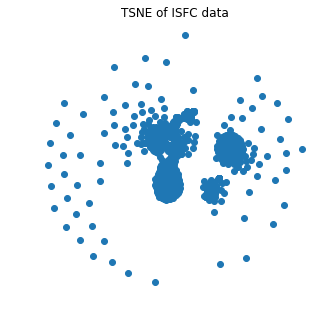

In [43]:
# Create the TSNE object
tsne = TSNE(n_components=2, metric="precomputed", random_state=0)
results = tsne.fit(1 - isfc_group)

# Pull out the coordinates
coords = results.embedding_

# Plot the data
plt.figure(figsize=(5,5))
plt.title('TSNE of ISFC data')
plt.axis('off')
plt.scatter(coords[:,0], coords[:,1])

From this plot there are hints that some clustering might exist but we want to assess this rigorously. Hierarchical clustering links all points in this plot that are within some scale parameter. So when the scale parameter is low, only small clusters can form but when it is larger, big clusters form. It is called hierarchical clustering because we care about the hierarchy of how these clusters form.

In [44]:
print('Clustering ISFC...')

# Use the ward method to perform hierarchical clustering
linkage_clustering = linkage(1 - isfc_group, method='ward')

Clustering ISFC...


Dendrograms represent the hierarchical clustering at different scales very clearly: at the bottom of the graph, when the scale is low, there are many separate and small clusters but as the scale increases (going up the y axis) the clusters merge with one another until there are two strong clusters that themselves eventually merge.

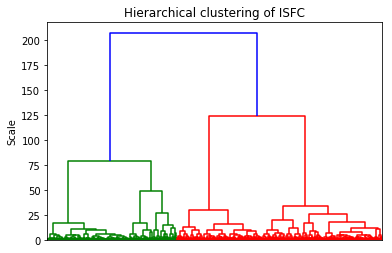

In [45]:
# Plot the dendrogram of this hierarchical clustering
plt.figure()
dn = dendrogram(linkage_clustering)
plt.title('Hierarchical clustering of ISFC')
plt.ylabel('Scale')
plt.xticks([])  # Prevent congestion
plt.show()

In [46]:
# Identify the coordinates of the max 2 clusters
cluster_labels = fcluster(linkage_clustering, t=2, criterion='maxclust')

# Order the indexes specifying the 
clust_inds = np.argsort(cluster_labels)

We can now rearrange the data in terms of this clustering

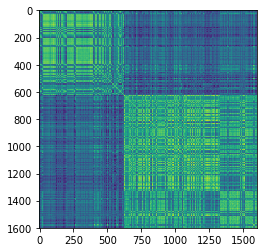

In [47]:
# Show the ISFC matrix, sorted to show the two main clusters of data
plt.figure()
# Create a tuple of indexes, useful when doing this type of indexing
coords = np.ix_(clust_inds,clust_inds)

# Plot the clustered ISFC
plt.imshow(isfc_group[coords])
plt.show()

**Exercise 4:**<a id="ex4"></a> Perform another type of clustering and plot the results like above. A good resource for clustering algorithms is the [scikit-learn clustering module](http://scikit-learn.org/stable/modules/clustering.html). Recommended options: K-means, spectral clustering. Write a description below of what the clustering procedure you used is doing.

**A:**

In [ ]:
# Insert code here

As mentioned above, these are clusters in activity space. However, we can visualize where these voxels are in the brain. Below we plot the clusters in white and orange.

In [48]:
# Identify the two cluster groups for the ISFC mask you created
cluster_mask = np.zeros(isc_mask.shape)
cluster_mask[np.where(isc_mask)] = cluster_labels  # Map the cluster labels on to the mask vector

# Load in the brain data for reference
brain_nii = nib.load(mask_name)
vol = np.zeros(brain_nii.shape)

# Get the list of nonzero voxel coordinates
coords = np.where(brain_mask)

# Map the ISC data into brain space
vol[coords] = cluster_mask

# Save the ISC data as a volume
out_nifti = nib.Nifti1Image(vol, brain_nii.affine, brain_nii.header)
nib.save(out_nifti, dir_out + '/ISFC_clusters.nii.gz')

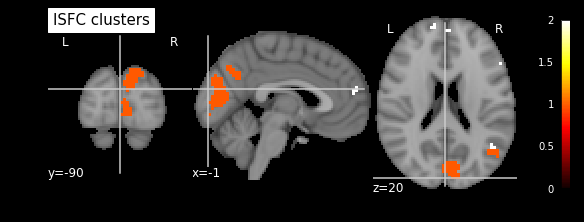

In [49]:
# Plot the data as ROIs
plotting.plot_stat_map(dir_out + '/ISFC_clusters.nii.gz',
                  title='ISFC clusters',
                  cut_coords=(-1,-90,20),
                  black_bg=True);

**Exercise 5:**<a id="ex5"></a> Create a good visualization of the orange cluster and plot it using the [nilearn.plotting tools](http://nilearn.github.io/plotting/index.html). Report in which anatomical region(s) this clustser can be found. (Hint: use nilearn, neurosynth, and/or fslview atlases)

**A:**

### 1.6 Permute ISFC  <a id="perm"></a>

Although we might have an ISC or ISFC map, it is hard to know what the values mean in terms of significance. BrainIAK provides methods to do permutation testing: phase-scramble the data and re-run the analyses in order to get a null distribution of results. You can then get a p-value for the correlation coefficient to determine whether it is reliable or not.

In [50]:
_, p_perm = brainiak.isfc.isfc(images_isc_masked,
                               return_p=True, 
                               random_state=1000, 
                               num_perm=10)

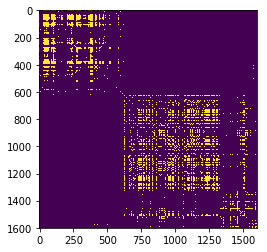

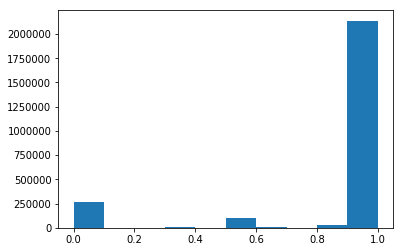

In [51]:
# Create a heat map of voxels that are significant relative to chance from the permutation testing
plt.figure()
plt.imshow(p_perm[np.ix_(clust_inds,clust_inds)] < 0.001)

# Plot the distribution of p values
plt.figure()
plt.hist(p_perm.flatten());

# Note that this is double dipping because of the ISC feature selection and so p values can be inflated 

## 2. Shared response modeling <a id="srm_wf"></a>


SRM is a functional alignment technique that maps participants into a shared, low-dimensionality feature space. Once SRM has been fit, other data from the same participants can be transformed into this space to be used as input to other analyses.

SRM assumes that each participant was exposed to a common sequence of events or a shared stimulus. For this reason, movies or audioclips are typically used, although experiments (e.g. face/scene discrimination) where the trials are in the same order across participants have also been used with SRM. If counterbalancing was used between participants, it is technically possible to still perform SRM by rearranging the data, although mileage may vary. For best results, the units that are counterbalanced ought to be long (e.g. >30s). 

It is also important to note that SRM needs a lot of data to train on: up to 400 TRs are necessary to get stable performance. Here we only have ~300 TRs total per participant, which will be carved up into smaller chunks, meaning that we should not expect exceptional performance.

The logic of SRM is as follows: The brain data for each participant is transformed into a n voxel by t time matrix. A certain number of k features are used to learn the mapping from voxel space into this shared space S. Every voxel in the brain loads on to these k features, which means a voxel has a weight w for the k features. w is first randomly initialized and then fit over a series of iterations to minimize the error in explaining the participant data. At the same time, the time course of these k features in the shared space is learnt.

![image](https://media.springernature.com/m685/nature-assets/neuro/journal/v20/n3/images/nn.4499-F4.jpg)

### 2.1 Data File Preparation <a id="data_prep_srm"></a>

BrainIAK has methods to efficiently load data. Fortunately, these are the same as ISC and ISFC.

In [52]:
# You have loaded these already
vox_num, nTR, num_subs = images_concatenated.shape  # Pull out the shape data

print('Participants ', num_subs)
print('Voxels per participant ', vox_num)
print('TRs per participant ', nTR)

Participants  4
Voxels per participant  67518
TRs per participant  300


Let's separate the data into training and test sets. In this case we are going to split each participant's data down the middle, using the first half for training and the second half for testing.

In [53]:
train_data = []
test_data = []
for sub in range(num_subs):
    train_data.append(images_concatenated[:, :nTR//2, sub])  # Take the first half of TRs as training (The double dash means integer division)
    test_data.append(images_concatenated[:, nTR//2:, sub])  # Take the second half of TRs as testing (The double dash means integer division)

We also want to normalize the data so that the scale is appropriate.

In [54]:
# Iterate through the subjects
for sub in range(num_subs):
    
    # Do it for training data
    train_data[sub] = stats.zscore(train_data[sub],
                                   axis=1,
                                   ddof=1)
    train_data[sub] = np.nan_to_num(train_data[sub])
    
    # Do it for test data
    test_data[sub] = stats.zscore(test_data[sub],
                                  axis=1,
                                  ddof=1)
    test_data[sub] = np.nan_to_num(test_data[sub])

/home/NEU350/software/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2245: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


### 2.2 SRM: training data <a id="srm_training"></a>

We are now ready to fit the data with SRM. First we create an object in BrainIAK with a specified number of features and iterations. We then fit this to our data.

In [55]:
features = 50  # How many features will you fit?
n_iter = 20  # How many iterations of fitting will you perform

# Create the SRM object
srm = brainiak.funcalign.srm.SRM(n_iter=n_iter, 
                                 features=features,
                                )

# Fit the SRM data
print('Fitting SRM, may take a few minutes ...')
srm.fit(train_data)

print('SRM has been fit')

Fitting SRM, may take a few minutes ...
SRM has been fit


To better understand the SRM model that was just created, we can explore the newly fitted data. Let's view the time course of the shared response captured by each feature. 

SRM: Features X Time Points  (50, 150)


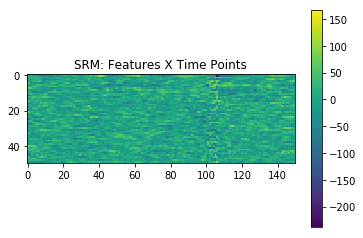

In [56]:
# Plot the shared response
print('SRM: Features X Time Points ', srm.s_.shape)
plt.figure()
plt.title('SRM: Features X Time Points')
plt.imshow(srm.s_, cmap='viridis')
plt.colorbar()

We can now use this shared response to estimate how similar each timepoint is to one another. We can treat each time point as dot in *k* dimensional space and then calculate the distance between all points in this space. If the points are close to one another then that indicates that they are similar. In the case below, blue means more similar. The red bands indicate time points where the patterns of activity diverge, potentially reflecting a unique time point in the data.

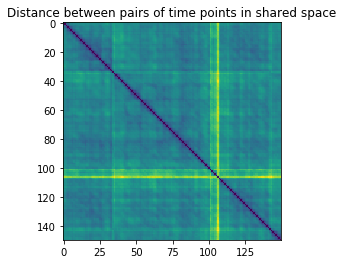

In [57]:
dist_mat = sp_distance.squareform(sp_distance.pdist(srm.s_.T))
plt.figure()
plt.title('Distance between pairs of time points in shared space')
plt.imshow(dist_mat)

In addition to the shared response matrix, we now also have a voxels x features weight matrix for each participant that specifies how to map them into the shared space. This is essentially a functional alignment transformation matrix. Let's visualize the weights associated with each feature for a given voxel.

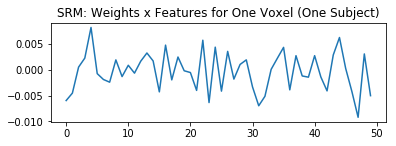

In [58]:
plt.subplot(211)
plt.title('SRM: Weights x Features for One Voxel (One Subject)')
srm.w_[0].shape
plt.plot(srm.w_[0][1,:])

The weight matrices are not only useful for projecting new data into a shared space but also for the reverse -- reconstructing data in subject space. This reconstructed activity is denoised because only the variance that was shared across participants. We do this below with the dot product of the weights for the first participant with the shared response feature time courses.

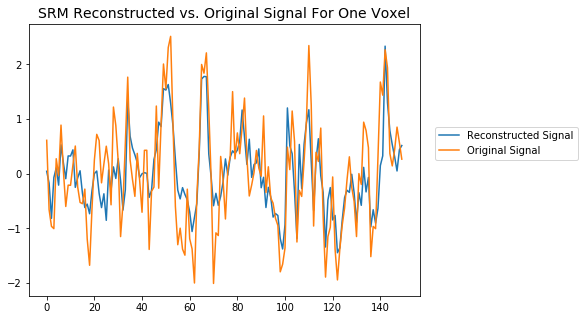

In [59]:
w0 = srm.w_[0]  # Weights for subject 1
S = srm.s_  # Shared response
signal_srm0 = w0.dot(S)  # Reconstructed signal

plt.figure(figsize=(7,5))
plt.title('SRM Reconstructed vs. Original Signal For One Voxel', fontsize=14)
plt.plot(signal_srm0[1,:])
plt.plot(train_data[0][1,:])

plt.legend(('Reconstructed Signal', 'Original Signal'), loc=(1.04,0.5))


We can also transform (i.e., functionally align) individual participant data into the shared space. This means that each participant is represented as a *k* by *t* matrix based on what components of their brain activity was shared with other participants.

Insofar as SRM worked, these feature time courses should be more similar across participants than the original voxel activity. We can test this with ISC: even though the shared features aren't in brain space, we can still use them as input to the ISC function.

In [60]:
# Transform the SRM data into shared space
shared_train = srm.transform(train_data)

# Reorganize the data back into an appropriate space for ISC
raw_obj = np.zeros((train_data[0].shape[0], train_data[0].shape[1], len(train_data)))
for ppt in range(len(train_data)):
    raw_obj[:, :, ppt] = train_data[ppt]
    
# Perform ISC on all participants, collapsing across participants    
corr_raw = brainiak.isfc.isc(raw_obj)
corr_raw = np.nan_to_num(corr_raw)  

# Reorganize the data back into an appropriate space for ISC
shared_obj = np.zeros((shared_train[0].shape[0], shared_train[0].shape[1], len(train_data)))
for ppt in range(len(train_data)):
    shared_obj[:, :, ppt] = shared_train[ppt]
    
# Perform ISC on all participants, collapsing across participants        
corr_shared = brainiak.isfc.isc(shared_obj)
corr_shared = np.nan_to_num(corr_shared)

/home/NEU350/software/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Independent samples t test between raw and SRM transformed data: 48.19007285335676 p: 0.0


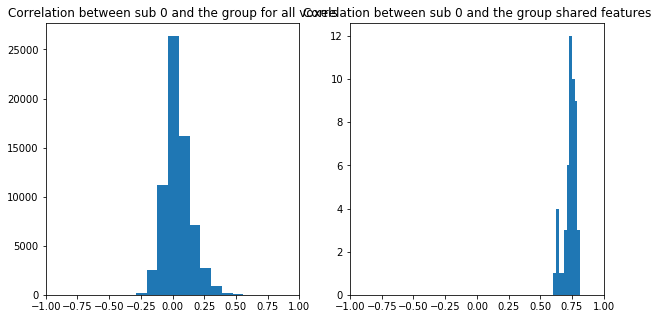

In [61]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Correlation between sub 0 and the group for all voxels')
plt.hist(corr_raw);
plt.xlim([-1, 1]);

plt.subplot(1, 2, 2)
plt.title('Correlation between sub 0 and the group shared features')
plt.hist(corr_shared);
plt.xlim([-1, 1]);

# Note: this data should be Fisher Z transformed before any statistics are done. Currently these statistics are invalid
tstat = stats.ttest_ind(corr_shared, corr_raw)
print('Independent samples t test between raw and SRM transformed data:', tstat.statistic, 'p:', tstat.pvalue)

**Exercise 6:**<a id="ex6"></a> Why does this work so well? What's wrong and how can you fix it?

**A**:

### 2.3 SRM: Test data <a id="srm_testing"></a>

We held out some data that were never seen by SRM and can use them to evaluate performance. If the dataset had other kinds of tasks (e.g., face vs. scene), we could similarly use the model to functionally align those data prior to performing other analyses (e.g., classification).

In [62]:
# Transform the test data into the shared space using the individual weight matrices
shared_test = srm.transform(test_data)

# Normalize data
for subject in range(num_subs):
    shared_test[subject] = stats.zscore(shared_test[subject], axis=1, ddof=1)

**Exercise 7:**<a id="ex7"></a> Repeat the analysis above in the test set, comparing ISC in the original voxel space vs. the shared feature space. Interpret your findings.

In [ ]:
# Insert code


**A:**

**Exercise 8:** <a id="ex8"></a> In the analyses above we selected 100 features arbitrarily. This is an assumption about the dimensionality of the shared response. Find a *k* that leads to better SRM performance in the **test** set, defined as the statistical difference between raw and shared ISC. Try at least one lower and one higher value.

### 2.4 Time segment matching

One of the ways to validate SRM is to show how well it can predict the epoch of time that some data corresponds to. The following function takes in a list of participant data and rotates through participants leaving one out for testing. The activity in all the other participants is averaged and effectively correlated with the held out participant, much like an ISC analysis. This is somewhat more nuanced though since it also creates a sliding window over which to compare the data between these two groups.

In [63]:
# Take in a list of participants of voxel by TR data. Also specify how big the time segment is to be matched
def time_segment_matching(data, 
                          win_size=10,
                         ):
     
    # Pull out shape information    
    n_subjs = len(data)
    (n_features, n_TR) = data[0].shape  # Voxel/feature by timepoint

    # How many segments are there (account for edges)
    n_seg = n_TR - win_size 
    
    # mysseg prediction prediction
    train_data = np.zeros((n_features*win_size, n_seg))

    # Concatenate the data across participants
    for ppt_counter in range(n_subjs):
        for window_counter in range(win_size):
            train_data[window_counter * n_features:(window_counter + 1)*n_features, :] += data[ppt_counter][:, window_counter:window_counter + n_seg]
    
    # Iterate through the participants, leaving one out
    accuracy = np.zeros(shape=n_subjs)
    for ppt_counter in range(n_subjs):
        
        # Preset
        test_data = np.zeros((n_features * win_size, n_seg))
        
        for window in range(win_size):
            test_data[window_counter * n_features:(window_counter + 1) * n_features,:] = data[ppt_counter][:,window_counter:(window_counter + n_seg)]
        
        # Take this participant data away
        train_ppts =  stats.zscore((train_data - test_data), 
                                   axis=0, 
                                   ddof=1)
        test_ppts =  stats.zscore(test_data,
                                  axis=0, 
                                  ddof=1)
        
        # Correlate the two data sets
        corr_mtx = test_ppts.T.dot(train_ppts)
        
        # If any segments have a correlation difference less than the window size and they aren't the same segments then set the value to negative infinity
        for seg_1 in range(n_seg):
            for seg_2 in range(n_seg):
                if abs(seg_1 - seg_2) < win_size and seg_1 != seg_2:
                    corr_mtx[seg_1, seg_2] = -np.inf
        
        # Find the segement with the max value
        rank =  np.argmax(corr_mtx, axis=1)
        
        # Find the number of segments that were matched for this participant
        accuracy[ppt_counter] = sum(rank == range(n_seg)) / float(n_seg)
        
        # Print accuracy
        print("Accuracy for subj %d is: %0.2f" % (ppt_counter, accuracy[ppt_counter] ))
        
    print("The average accuracy among all subjects is {0:f} +/- {1:f}".format(np.mean(accuracy), np.std(accuracy)))

In [64]:
# Run for voxel data
time_segment_matching(train_data, win_size=10)

Accuracy for subj 0 is: 0.07
Accuracy for subj 1 is: 0.03
Accuracy for subj 2 is: 0.06
Accuracy for subj 3 is: 0.02
The average accuracy among all subjects is 0.044643 +/- 0.020438


In [65]:
# Run for SRM data
time_segment_matching(shared_train, win_size=10)

Accuracy for subj 0 is: 0.99
Accuracy for subj 1 is: 0.94
Accuracy for subj 2 is: 0.99
Accuracy for subj 3 is: 0.99
The average accuracy among all subjects is 0.978571 +/- 0.020825


**Exercise 9:**<a id="ex8"></a> Perform time segment matching on both raw and SRM transformed test data.

**Novel contribution:**<a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.

### Contributions<a id="contributions"></a>

E. Simony and U. Hasson for providing data  
C. Baldassano and C. Chen provided initial code  
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 4/4/18  